# Dementia Classification Project

This notebook shows an example custom training pipeline for contrastive learning. 

* Modifications are made to the dataset generator and neural network model. 
* For the sake of this example, no files are logged or saved.

**Important, when training this model, input_selection used conv with strides=s and kernel_size=kernel_size.**

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from jarvis.utils.general import gpus, overload

from tfcaidm import Jobs
from tfcaidm import JClient
from tfcaidm import Dataset
from tfcaidm import Model
from tfcaidm import Trainer

**Autoselect GPU (use only on caidm cluster)**

In [2]:
gpus.autoselect()

[ 2021-11-12 15:02:08 ] CUDA_VISIBLE_DEVICES automatically set to: 3           


## Define experiment


---

**Purpose**

Compare the performance of a model trained using `supervised cross-entropy` vs. `supervised contrastive learning`.

**Details**

* `Dataset`: AV45 and FDG scans of the brain from [ADNI](http://adni.loni.usc.edu/) with `2733 scans in total`.
    * Class balanced for entire dataset is `753 positive cases` and `1980 negative cases`, with the training and validation set comprimising approx. `~30% (dementia)` vs. `~70% (no dementia)`.
* `Model`: A fully convolutional encoder network. This network is shared between two inputs known as `anc` (anchor) and `unk` (unknown, either positive or negative)
* `Training`: Given a batch of N samples, 1 scan (`anc`) is compared (contrasted) to N-1 other scans (`unks`), yielding an effect batch size of N-1
    * The model is trained on a 75/25 train/validation split, 2733 total scans, 2064 scans for training, 669 scans for validation.
* `Metric`: Accuracy between predicted classes (dementia vs. normal).

**Results**

Based on the brief experiment below, the standard supervised cross-entropy training scheme outperforms supervised contrastive learning, while a combo loss of cross-entropy and contrastive performs the best.

**Winner: supervised cross-entropy plus contrastive learning.**

---

### Get hyperparameters

In [ ]:
YAML_PATH = "/home/brandon/tfcaidm-pkg/configs/ymls/adni/pipeline.yml"

In [3]:
# --- Get hyperparameters
runs = Jobs(path=YAML_PATH)

# --- Hyperparameters for N runs
all_hyperparams = runs.get_params()

# ---- Hyperparameters for first run
hyperparams = all_hyperparams[0]

In [4]:
pd.DataFrame(hyperparams).iloc[0]

env/path/client                 /home/brandon/tfcaidm-pkg/configs/ymls/adni/cl...
model/model                                                                ae
model/conv_type                                                          conv
model/pool_type                                                          conv
model/eblock                                                             conv
model/elayer                                                                1
model/dblock                                                             conv
model/depth                                                                 6
model/width                                                                 4
model/width_scaling                                                         2
model/kernel_size                                                           3
model/strides                                                               2
model/bneck                                                 

### Custom dataset generator

In [5]:
# --- Modify dataset generator (applies same modification to train and valid generators)
@overload(JClient)
def create_generator(self, gen_data):
    for x, y in gen_data:
        
        """Each training pass will consist of N-1 contrastive comparisons"""
        """Note using custom layers so inputs and outputs are stored in x"""

        # --- Prepare ground-truths
        xs = x["dat"]
        ys = x["lbl"]
        assert xs.shape[0] > 1 and ys.shape[0] > 1, "ERROR! Batch size (N) must be at least 2!"

        xs_unk = xs[:-1]
        ys_unk = ys[:-1]
        xs_anc = np.stack([xs[-1]] * len(xs_unk))
        ys_anc = np.stack([ys[-1]] * len(ys_unk))

        # --- Assign ground-truths
        xs = {}
        ys = {}

        xs["anc"] = xs_anc
        xs["unk"] = xs_unk
        ys["ctr"] = tf.cast((ys_anc == ys_unk), tf.float32)
        ys["cls_anc"] = ys_anc
        ys["cls_unk"] = ys_unk

        yield xs, ys

### Custom loss functions

In [ ]:
def BCE(weights=None):
    loss = losses.BinaryCrossentropy()
    
    def binary_cross_entropy(y_true, y_pred):
        return loss(y_true=y_true, y_pred=y_pred, sample_weight=weights)
    return binary_cross_entropy

In [6]:
def cosine_similarity(vects):
    a, b = vects
    cosim = layers.Dot(axes=-1, normalize=True)([a, b])
    cosim = layers.Reshape((1, 1, 1, 1))(cosim)
    
    return 1 - cosim

def CTR(weighst=1, margin=1):
    
    def contrastive_loss(y_true, y_pred):
        square_pred = tf.math.square(y_pred) * weights
        margin_square = tf.math.square(tf.math.maximum((margin - y_pred), 0)) * weights
        loss = tf.math.reduce_mean(y_true * margin_square + (1 - y_true) * square_pred)
        return loss

    return contrastive_loss

### Custom model

#### 1. Shared encoder model

In [7]:
from tfcaidm.models import head
from tfcaidm.models import registry

In [8]:
def AE(INPUT_SHAPE, hyperparams):
    autoencoder = registry.available_models()["ae"]
    
    # --- Extract hyperparams
    n = hyperparams["model"]["depth"]
    c = hyperparams["model"]["width"]
    k = hyperparams["model"]["kernel_size"]
    s = hyperparams["model"]["strides"]
    
    features = autoencoder(INPUT_SHAPE, n, c, k, s, hyperparams)
    
    # --- Extract bottom of AutoEncoder
    embed = head.Encoder.last_layer(**features)

    # --- NOTE: The below hyperparameters will not be logged!
    conv = lambda filters, name: layers.Conv3D(
        filters=filters,
        kernel_size=1,
        activation="sigmoid",
        name=name,
        padding="same",
    )

    ftr = layers.GlobalAveragePooling3D()(embed)
    ftr = layers.Reshape((1, 1, 1, embed.shape[-1]))(ftr)
    ctr = conv(filters=10, name="ctr")(ftr)
    cls = conv(filters=1, name="cls")(ctr)

    logits = {}
    logits["ctr"] = ctr
    logits["cls"] = cls

    return logits

#### 2. Apply loss and compile model

In [9]:
from tensorflow import optimizers
from tensorflow.keras import Input, layers, metrics, losses

In [10]:
def dementia_model(loss_weights):

    @overload(Model)
    def create(self):

        INPUT_SHAPE = (96, 160, 160, 1)
        inputs = Input(shape=INPUT_SHAPE)
        outputs = AE(inputs, self.hyperparams)

        # --- Create tensorflow model
        backbone = self.assemble(inputs=inputs, outputs=outputs)

        inputs = {
            "anc": Input(shape=INPUT_SHAPE, name="anc"),
            "unk": Input(shape=INPUT_SHAPE, name="unk"),
        }

        # --- Define contrastive network
        anc_net = backbone(inputs=inputs["anc"])
        unk_net = backbone(inputs=inputs["unk"])

        # --- Cosine similarity embeddings
        ctr = layers.Lambda(cosine_similarity)([anc_net["ctr"], unk_net["ctr"]])

        logits = {}
        logits["ctr"] = layers.Layer(name="ctr")(ctr)
        logits["cls_anc"] = layers.Layer(name="cls_anc")(anc_net["cls"])
        logits["cls_unk"] = layers.Layer(name="cls_unk")(unk_net["cls"])

        # --- Create tensorflow model
        model = self.assemble(inputs=inputs, outputs=logits)

        model.compile(
            optimizer=optimizers.Adam(learning_rate=self.hyperparams["train"]["trainer"]["lr"]),
            loss={
                "ctr": CTR(),
                "cls_anc": BCE(),
                "cls_unk": BCE(),
            },
            loss_weights={
                "ctr": loss_weights["ctr"],
                "cls_anc": loss_weights["cls_anc"],
                "cls_unk": loss_weights["cls_unk"],
            },
            metrics={
                "cls_anc": metrics.BinaryAccuracy(),
                "cls_unk": metrics.BinaryAccuracy(),
            },
            experimental_run_tf_function=False,
        )

        return model

### Train model

In [11]:
def train():
    client = Dataset(hyperparams).get_client(0)
    gen_train, gen_valid = client.create_generators(test=False)

    model = Model(client).create()

    trainer = Trainer(hyperparams)
    results = trainer.fit(model, gen_train, gen_valid, callbacks=None)
    
    return results

In [12]:
cross_entropy = {"ctr": 0, "cls_anc": 1, "cls_unk": 1}
contrastive = {"ctr": 1, "cls_anc": 0, "cls_unk": 0}
combo = {"ctr": 1, "cls_anc": 1, "cls_unk": 1}

#### 1. Cross-entropy model

In [13]:
dementia_model(cross_entropy)
r1 = train()

(None, 96, 160, 160, 4)
(None, 48, 80, 80, 8)
(None, 24, 40, 40, 16)
(None, 12, 20, 20, 32)
(None, 6, 10, 10, 64)
(None, 3, 5, 5, 128)
(None, 2, 3, 3, 256)
(None, 4, 6, 6, 128)
(None, 8, 12, 12, 64)
(None, 16, 24, 24, 32)
(None, 32, 48, 48, 16)
(None, 64, 96, 96, 8)
(None, 128, 192, 192, 4)
Epoch 1/10
100/100 [==============================] - 147s 1s/step - loss: 1.4623 - cls_anc_loss: 0.7339 - cls_unk_loss: 0.7284 - ctr_loss: 0.4722 - cls_anc_binary_accuracy: 0.5100 - cls_unk_binary_accuracy: 0.5150
Epoch 2/10
100/100 [==============================] - 137s 1s/step - loss: 1.3059 - cls_anc_loss: 0.7185 - cls_unk_loss: 0.5874 - ctr_loss: 0.4087 - cls_anc_binary_accuracy: 0.4200 - cls_unk_binary_accuracy: 0.6875
Epoch 3/10
100/100 [==============================] - 136s 1s/step - loss: 1.1149 - cls_anc_loss: 0.6323 - cls_unk_loss: 0.4825 - ctr_loss: 0.3906 - cls_anc_binary_accuracy: 0.5500 - cls_unk_binary_accuracy: 0.7950
Epoch 4/10
100/100 [==============================] - 144s 1s/s

#### 2. Contrastive model

In [14]:
dementia_model(contrastive)
r2 = train()

(None, 96, 160, 160, 4)
(None, 48, 80, 80, 8)
(None, 24, 40, 40, 16)
(None, 12, 20, 20, 32)
(None, 6, 10, 10, 64)
(None, 3, 5, 5, 128)
(None, 2, 3, 3, 256)
(None, 4, 6, 6, 128)
(None, 8, 12, 12, 64)
(None, 16, 24, 24, 32)
(None, 32, 48, 48, 16)
(None, 64, 96, 96, 8)
(None, 128, 192, 192, 4)
Epoch 1/10
100/100 [==============================] - 149s 1s/step - loss: 0.3593 - cls_anc_loss: 0.7875 - cls_unk_loss: 0.8640 - ctr_loss: 0.3593 - cls_anc_binary_accuracy: 0.5100 - cls_unk_binary_accuracy: 0.4975
Epoch 2/10
100/100 [==============================] - 142s 1s/step - loss: 0.3066 - cls_anc_loss: 0.8494 - cls_unk_loss: 0.8131 - ctr_loss: 0.3066 - cls_anc_binary_accuracy: 0.4200 - cls_unk_binary_accuracy: 0.5325
Epoch 3/10
100/100 [==============================] - 142s 1s/step - loss: 0.3023 - cls_anc_loss: 0.7375 - cls_unk_loss: 0.7981 - ctr_loss: 0.3023 - cls_anc_binary_accuracy: 0.5500 - cls_unk_binary_accuracy: 0.5425
Epoch 4/10
100/100 [==============================] - 143s 1s/s

#### 3. Cross-entropy plus Contrastive model

In [15]:
dementia_model(combo)
r3 = train()

(None, 96, 160, 160, 4)
(None, 48, 80, 80, 8)
(None, 24, 40, 40, 16)
(None, 12, 20, 20, 32)
(None, 6, 10, 10, 64)
(None, 3, 5, 5, 128)
(None, 2, 3, 3, 256)
(None, 4, 6, 6, 128)
(None, 8, 12, 12, 64)
(None, 16, 24, 24, 32)
(None, 32, 48, 48, 16)
(None, 64, 96, 96, 8)
(None, 128, 192, 192, 4)
Epoch 1/10
100/100 [==============================] - 149s 1s/step - loss: 1.8884 - cls_anc_loss: 0.7347 - cls_unk_loss: 0.7360 - ctr_loss: 0.4177 - cls_anc_binary_accuracy: 0.5100 - cls_unk_binary_accuracy: 0.5250
Epoch 2/10
100/100 [==============================] - 143s 1s/step - loss: 1.6777 - cls_anc_loss: 0.7218 - cls_unk_loss: 0.6112 - ctr_loss: 0.3447 - cls_anc_binary_accuracy: 0.4200 - cls_unk_binary_accuracy: 0.6575
Epoch 3/10
100/100 [==============================] - 143s 1s/step - loss: 1.4627 - cls_anc_loss: 0.6328 - cls_unk_loss: 0.4983 - ctr_loss: 0.3316 - cls_anc_binary_accuracy: 0.5500 - cls_unk_binary_accuracy: 0.7850
Epoch 4/10
100/100 [==============================] - 144s 1s/s

### Save models

In [20]:
r1.model.save("./models/cross_entropy")
r2.model.save("./models/contrastive")
r3.model.save("./models/combo")

INFO:tensorflow:Assets written to: ./models/cross_entropy/assets
INFO:tensorflow:Assets written to: ./models/contrastive/assets
INFO:tensorflow:Assets written to: ./models/combo/assets


### Evaluate models

During inference we only care if a model can tell us disease or no disease, so we will modify the generator accordingly.

In [44]:
@overload(JClient)
def create_generator(self, gen_data):
    for x, y in gen_data:

        # --- Prepare ground-truths
        xs = x["dat"]
        ys = x["lbl"]

        xs_unk = xs
        ys_unk = ys
        xs_anc = xs
        ys_anc = ys

        # --- Assign ground-truths
        xs = {}
        ys = {}

        xs["anc"] = xs_anc
        xs["unk"] = xs_unk
        ys["ctr"] = tf.cast((ys_anc == ys_unk), tf.float32)
        ys["cls_anc"] = ys_anc
        ys["cls_unk"] = ys_unk

        yield xs, ys

#### 1. Cross-entropy model

In [361]:
client = Dataset(hyperparams).get_client(0)
gen_train, gen_valid = client.create_generators(test=True)

In [56]:
e1 = r1.model.evaluate(
    x=gen_valid,
    batch_size=1,
    verbose=0,
    return_dict=True,
)

e1

[ 2021-11-12 16:41:20 ] [====================] 100.000% : Iterating | 000669      

{'loss': 0.9038854241371155,
 'cls_anc_loss': 0.45194271206855774,
 'cls_unk_loss': 0.45194271206855774,
 'ctr_loss': 9.309278337348709e-15,
 'cls_anc_binary_accuracy': 0.7623318433761597,
 'cls_unk_binary_accuracy': 0.7623318433761597}

#### 2. Contrastive model

In [57]:
client = Dataset(hyperparams).get_client(0)
gen_train, gen_valid = client.create_generators(test=True)

In [58]:
e2 = r2.model.evaluate(
    x=gen_valid,
    batch_size=1,
    verbose=0,
    return_dict=True,
)

e2

[ 2021-11-12 16:42:22 ] [====================] 100.000% : Iterating | 000669        

{'loss': 1.2299080177425366e-14,
 'cls_anc_loss': 0.5685886740684509,
 'cls_unk_loss': 0.5685886740684509,
 'ctr_loss': 1.2299080177425366e-14,
 'cls_anc_binary_accuracy': 0.738415539264679,
 'cls_unk_binary_accuracy': 0.738415539264679}

#### 3. Cross-entropy plus Contrastive model

In [333]:
client = Dataset(hyperparams).get_client(0)
gen_train, gen_valid = client.create_generators(test=True)

In [60]:
e3 = r3.model.evaluate(
    x=gen_valid,
    batch_size=1,
    verbose=0,
    return_dict=True,
)

e3

[ 2021-11-12 16:43:25 ] [====================] 100.000% : Iterating | 000669       

{'loss': 0.7437570095062256,
 'cls_anc_loss': 0.3718785047531128,
 'cls_unk_loss': 0.3718785047531128,
 'ctr_loss': 1.0068677255880079e-14,
 'cls_anc_binary_accuracy': 0.8430493474006653,
 'cls_unk_binary_accuracy': 0.8430493474006653}

### Dataset statistics

This is usually done at the very beginning of every data science project.

In [68]:
train_0 = client.db.header["valid"] != 0
valid_0 = client.db.header["valid"] == 0

trainset_0 = client.db.header[train_0]
validset_0 = client.db.header[valid_0]

In [69]:
trainset_0

,Unnamed: 0,Unnamed: 0.1,valid,AD,CN,AV45,FDG,AD_AV45,AD_FDG,CN_AV45,CN_FDG,mu,sd
0,0,0,3,False,True,False,True,False,False,False,True,0.243837,0.405409
1,1,1,3,False,True,True,False,False,False,True,False,0.414004,0.662678
2,2,2,2,False,True,True,False,False,False,True,False,0.272239,0.413432
3,3,3,2,False,True,False,True,False,False,False,True,0.202763,0.384615
4,4,4,2,False,True,True,False,False,False,True,False,0.337266,0.529944
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2728,2728,2728,1,False,True,True,False,False,False,True,False,0.334213,0.502106
2729,2729,2729,1,False,True,False,True,False,False,False,True,0.204735,0.379556
2730,2730,2730,1,False,True,True,False,False,False,True,False,0.333346,0.479243
2731,2731,2731,1,False,True,True,False,False,False,True,False,0.339025,0.489112


In [70]:
validset_0

,Unnamed: 0,Unnamed: 0.1,valid,AD,CN,AV45,FDG,AD_AV45,AD_FDG,CN_AV45,CN_FDG,mu,sd
26,26,26,0,False,True,False,True,False,False,False,True,0.212034,0.376122
27,27,27,0,False,True,True,False,False,False,True,False,0.350511,0.508642
28,28,28,0,False,True,True,False,False,False,True,False,0.361147,0.545707
29,29,29,0,False,True,False,True,False,False,False,True,0.207958,0.377676
30,30,30,0,False,True,True,False,False,False,True,False,0.372838,0.551733
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2723,2723,2723,0,False,True,False,True,False,False,False,True,0.260932,0.411736
2724,2724,2724,0,False,True,False,True,False,False,False,True,0.250744,0.418030
2725,2725,2725,0,False,True,True,False,False,False,True,False,0.428952,0.587187
2726,2726,2726,0,False,True,False,True,False,False,False,True,0.254812,0.418747


#### Computing the baseline accuracy

In [83]:
def baseline(df):
    acc = sum((df == True)) / len(df)
    
    if acc < 0.5:
        acc = 1 - acc
        
    return acc

In [284]:
baseline(validset_0["AD"])

0.7384155455904335

### Classification report

In [313]:
from tfcaidm.models import audit

In [334]:
true = []
pred1 = []
pred2 = []
pred3 = []

for xs, ys in gen_valid:
    true.append(ys["cls_anc"])
    pred1.append(r1.model(xs)["cls_anc"])
    pred2.append(r2.model(xs)["cls_anc"])
    pred3.append(r3.model(xs)["cls_anc"])

true = np.array(true)
pred1 = np.array(pred1)
pred2 = np.array(pred2)
pred3 = np.array(pred3)

[ 2021-11-14 21:24:55 ] [====================] 100.000% : Iterating | 000669    

#### 1. Cross-entropy model

In [338]:
clf1 = audit.Classification(r1.model)
print(clf1.classification_report(true, pred1 > 0.5))

              precision    recall  f1-score   support

           0       0.92      0.74      0.82       494
           1       0.53      0.82      0.64       175

    accuracy                           0.76       669
   macro avg       0.73      0.78      0.73       669
weighted avg       0.82      0.76      0.78       669



#### 2. Contrastive model

In [341]:
clf2 = audit.Classification(r2.model)
print(clf2.classification_report(true, pred2 > 0.5))

              precision    recall  f1-score   support

           0       0.74      1.00      0.85       494
           1       0.00      0.00      0.00       175

    accuracy                           0.74       669
   macro avg       0.37      0.50      0.42       669
weighted avg       0.55      0.74      0.63       669



/home/brandon/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brandon/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brandon/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### 3. Cross-entropy plus Contrastive model

In [340]:
clf3 = audit.Classification(r3.model)
print(clf3.classification_report(true, pred3 > 0.5))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89       494
           1       0.67      0.79      0.73       175

    accuracy                           0.84       669
   macro avg       0.80      0.83      0.81       669
weighted avg       0.86      0.84      0.85       669



### Embedding viz

The shape of the following plots corresponds to the dimensionality reduced embeddings from a given model.

* Yellow corresponds to the positive class (dementia)
* Purple corresponds to the negative class (no dementia)

In [382]:
from tensorflow.keras import Model as TFModel
from sklearn import decomposition, manifold

In [402]:
def get_model(model, layer_name):
    return TFModel(inputs=model.inputs, outputs=model.get_layer(layer_name).output)

In [478]:
def plot_embeddings(true, pred, emb, figsize=(12, 12)):
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')

    ax1.scatter(emb[:, 0], emb[:, 1], emb[:, 2], c=pred)
    ax2.scatter(emb[:, 0], emb[:, 1], emb[:, 2], c=true)
    
    ax1.set_title("Model Prediction")
    ax2.set_title("Ground-Truth")
    
    plt.show()
    

#### Get embedding models

In [409]:
emb1 = get_model(r1.model.layers[2], layer_name="ctr")
emb2 = get_model(r2.model.layers[2], layer_name="ctr")
emb3 = get_model(r3.model.layers[2], layer_name="ctr")

#### Get embeddings

In [413]:
client = Dataset(hyperparams).get_client(0)
gen_train, gen_valid = client.create_generators(test=True)

In [414]:
ctr1 = []
ctr2 = []
ctr3 = []

for xs, ys in gen_valid:
    ctr1.append(emb1(xs["anc"]))
    ctr2.append(emb2(xs["anc"]))
    ctr3.append(emb3(xs["anc"]))
    
ctr1 = np.array(ctr1).squeeze()
ctr2 = np.array(ctr2).squeeze()
ctr3 = np.array(ctr3).squeeze()

[ 2021-11-15 11:03:59 ] [====================] 100.000% : Iterating | 000669    

#### 1. Cross-entropy embeddings

##### PCA

In [479]:
pca1 = decomposition.PCA(n_components=3).fit_transform(ctr1)
plot_embeddings(true.squeeze(), pred1.squeeze() > 0.5, pca1)

##### TSNE

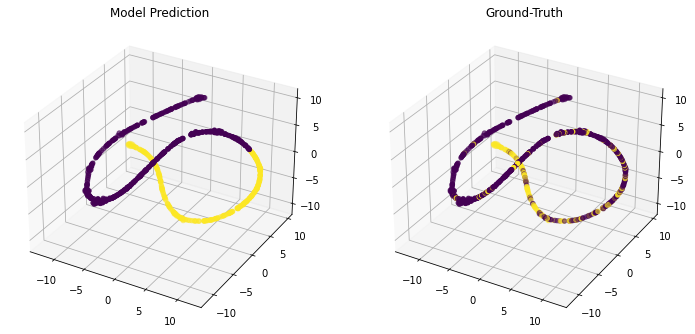

In [487]:
tsne1 = manifold.TSNE(n_components=3, learning_rate="auto", init="random", random_state=0).fit_transform(ctr1)
plot_embeddings(true.squeeze(), pred1.squeeze() > 0.5, tsne1)

#### 2. Contrastive embeddings

##### PCA

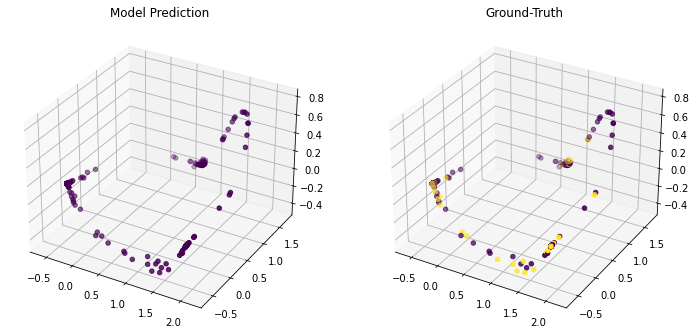

In [480]:
pca2 = decomposition.PCA(n_components=3).fit_transform(ctr2)
plot_embeddings(true.squeeze(), pred2.squeeze() > 0.5, pca2)

##### TSNE

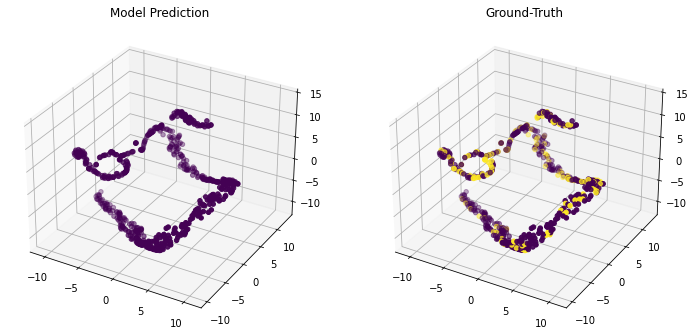

In [488]:
tsne2 = manifold.TSNE(n_components=3, learning_rate="auto", init="random", random_state=0).fit_transform(ctr2)
plot_embeddings(true.squeeze(), pred2.squeeze() > 0.5, tsne2)

#### 3. Cross-entropy plus Contrastive embeddings

##### PCA

In [486]:
pca3 = decomposition.PCA(n_components=3).fit_transform(ctr3)
plot_embeddings(true.squeeze(), pred3.squeeze() > 0.5, pca3)

##### TSNE

In [489]:
tsne3 = manifold.TSNE(n_components=3, learning_rate="auto", init="random", random_state=0).fit_transform(ctr3)
plot_embeddings(true.squeeze(), pred3.squeeze() > 0.5, tsne3)

### Model viz

Visualize model predictions with GradCAM. **Note only the best model (combo loss) will be visualized.**

In [114]:
from tfcaidm.models import viz

In [ ]:
gc = viz.GradCAM(r3.model.layers[2])

In [232]:
while True:
    xs, ys = next(gen_train)
    if np.squeeze(ys["cls_unk"]) == 1:
        break

xs["input_4"] = xs["anc"] # this is a hack, avoid this!

[ 2021-11-12 17:18:49 ] [=>..................] 5.329% : Iterating | 000110      

In [233]:
# (model pred, label)
r3.model.layers[2](xs["input_4"])["cls"].numpy().squeeze().item(), ys["cls_unk"].squeeze().item()

(0.683444619178772, 1)

In [234]:
hm = gc.heatmap(xs, layer=-5, output_name="cls", class_of_interest=0)
viz.overlay(xs["input_4"], hm.numpy(), figsize=(12, 12))

<Figure size 432x288 with 0 Axes>

### Model confidence

In [238]:
import matplotlib.pyplot as plt

In [250]:
def get_outputs(history):
    client = Dataset(hyperparams).get_client(0)
    gen_train, gen_valid = client.create_generators(test=True)

    preds = []
    trues = []

    for xs, ys in gen_valid:
        xs["input_4"] = xs["anc"]

        pred = history.model.layers[2](xs["input_4"])["cls"].numpy().squeeze().item()
        true = ys["cls_unk"].squeeze().item()

        preds.append(pred)
        trues.append(true)
        
    preds = np.array(preds)
    trues = np.array(trues)
    
    return preds, trues

In [482]:
def plot_hist(trues, preds, figsize=(12, 4)):
    fig, ax = plt.subplots(1, 2, figsize=figsize)

    ax[0].hist(trues)
    ax[1].hist(preds)
    
    ax[0].set_title("Model Prediction")
    ax[1].set_title("Ground-Truth")
    
    plt.show()

#### 1. Cross-entropy model

[ 2021-11-15 11:28:23 ] [====================] 100.000% : Iterating | 000669    

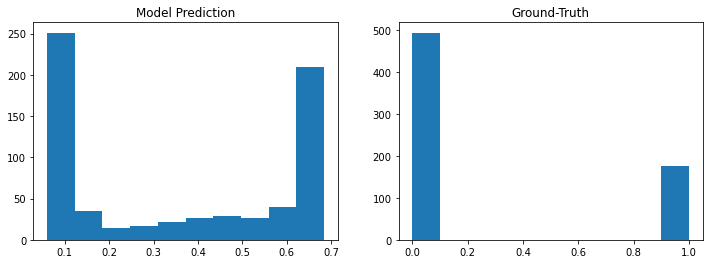

In [483]:
t1, p1 = get_outputs(r1)
plot_hist(t1, p1)

#### 2. Contrastive model

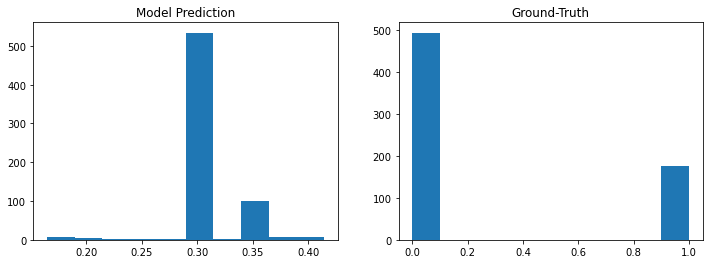

In [484]:
t2, p2 = get_outputs(r2)
plot_hist(t2, p2)

#### 3. Cross-entropy plus Contrastive model

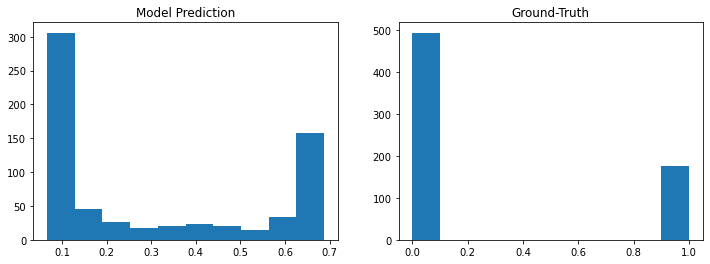

In [485]:
t3, p3 = get_outputs(r3)
plot_hist(t3, p3)

The purely supervised contrastive approach seemed to not have enough signal to separate the two classes as shown above. 

Adding an extra classifier head allowed the model to separate the two classes much better.

Furthermore, when comparing model `1.` and `3.`, we can see that the contrastive loss had a stronger effect of separating the classes near the decision boundary of 0.5

## Next Steps

* There is about a 1 to 2.5 class imbalance between AD (dementia) and CN (normal) patients, adding class weights could further producerine performance especially for the disease class.
    * This behavior seems to be in-line from the model confidence scores.
* Atrous 3D Convs or a 3D Vision Transformer seems like it would be a good candidate for this task as it can better attend to scans spaced further apart. 
    * The lack of data is not ideal for the transformer though.